# Training an ANN with fewer SynOps
As described in [Sorbaro et al. 2020](https://www.frontiersin.org/articles/10.3389/fnins.2020.00662/full), it can be beneficial for power consumption and latency in the network to reduce the number of synaptic operations (SynOps). This number is essentially the output activation multiplied by the number of outward connections (fan-out) to the next layer. We describe how using Sinabs' synops counters it's possible to easily add a term to your loss function which then can be minimised.

Let's start by defining our ANN and the training dataset. Keep in mind that we use NeuromorphicRelus here as we need to discretize the output in the forward pass to simulate the number of spikes that layer would emit. In the backward pass the derivative of the ReLU function is used. 

In [1]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl

# Seed for reproducibility
torch.manual_seed(1)

ann = nn.Sequential(
    nn.Conv2d(1, 16, 5, bias=False),
    sl.NeuromorphicReLU(),
    sl.SumPool2d(2),
    nn.Conv2d(16, 32, 5, bias=False),
    sl.NeuromorphicReLU(),
    sl.SumPool2d(2),
    nn.Conv2d(32, 120, 4, bias=False),
    sl.NeuromorphicReLU(),
    nn.Flatten(),
    nn.Linear(120, 10, bias=False),
)

In [2]:
from torch.utils.data import DataLoader
import torch
from torchvision import datasets, transforms

to_tensor = transforms.ToTensor()
mnist_train = datasets.MNIST("../tutorials/data", train=True, transform=lambda x: to_tensor(x)*255)
train_loader = DataLoader(mnist_train, batch_size=512, shuffle=True, num_workers=4)

Let's make our ANN track how many synaptic operations it would need in an SNN, given a single sample. The `sinabs.hooks` module in Sinabs provieds PyTorch style hooks that help collecting statistics on the network activity. For models of type `nn.Sequential`, setting up a hook for recording the synaptic operations can be done easily with a convenience function `register_synops_hooks` from the same module.

**Good to know:** Because the number of synaptic operations depends on the connections between layers, in Sinabs they are computed and stored at the level of weight (convolutional, linear) layers and can therefore be accessed through these.

In [3]:
from sinabs.hooks import register_synops_hooks

# Register the hooks with our ANN
register_synops_hooks(ann)

# Forward pass to record the number of synaptic operations
ann(mnist_train[0][0].unsqueeze(0));

After a forward pass the convolutional layers, as well as our ann itself each have an attribute `hook_data`. With this we can now read out the mean synaptic operations per time step for each layer individually, or the sum across all layers, respectively.

In [4]:
print("Synops after feeding input:")
print(f"Total: {ann.hook_data['total_synops_per_timestep']:.2e} SynOps per step")

You can also break down the statistics for each convolutional or linear layer.

In [10]:
print("Per layer:")
for layer_idx, synops in ann.hook_data["synops_per_timestep"].items():
    print(f"- Layer {layer_idx}: {synops:.2e} SynOps per step")

Per layer:
- Layer 0: 9.66e+06 SynOps per step
- Layer 3: 2.92e+07 SynOps per step
- Layer 6: 1.42e+05 SynOps per step
- Layer 9: 5.65e+03 SynOps per step


For the given sample the model produced around 100 million SynOps per time step. Let's try to bring this down to 40 million. To this end we add a term to our objective function that punishes values above this target.

In [5]:
from tqdm import tqdm

optim = torch.optim.Adam(ann.parameters(), lr=1e-3)
device = "cuda" if torch.cuda.is_available() else "cpu"
synops_loss_weight = 1e-5

# Fix the target number of operations
target_synops = torch.tensor(4e7, device=device)
ann = ann.to(device)
model_losses = []
synops_losses = []
for epoch in tqdm(range(2)):
    for data, target in iter(train_loader):
        data, target = data.to(device), target.to(device)
        output = ann(data)
        optim.zero_grad()

        model_loss = nn.functional.cross_entropy(output, target) 
        synops_loss = synops_loss_weight * nn.functional.mse_loss(ann.hook_data["total_synops_per_timestep"], target_synops) / 1e7
        loss = model_loss + synops_loss
        loss.backward()
        optim.step()
        model_losses.append(model_loss.item())
        synops_losses.append(synops_loss.item())

100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.99s/it]


Let's plot the results of both loss terms, one for the prediction and one for the synops. 

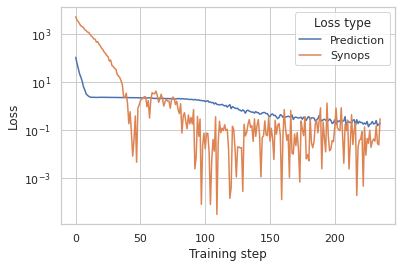

In [6]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

df = pd.DataFrame({
    'Loss type': ['Prediction'] * len(model_losses) + ['Synops'] * len(synops_losses),
    'Loss' : model_losses + synops_losses,
    'Training step' : list(range(len(model_losses))) + list(range(len(synops_losses)))
})
fig = sns.lineplot(data=df,  x='Training step', y='Loss', hue='Loss type')
fig.set_yscale("log");

Now let's check how we're doing in terms of prediction accuracy on the test set.

In [7]:
mnist_test = datasets.MNIST("../tutorials/data", train=False, transform=lambda x: to_tensor(x)*255)
test_loader = DataLoader(mnist_test, batch_size=512, num_workers=4)

In [8]:
from torchmetrics.classification import MulticlassAccuracy
metric = MulticlassAccuracy(num_classes=10, average='micro').to(device)

accuracies = []
for data, targets in iter(test_loader):
    data, targets = data.to(device), targets.to(device)
    with torch.no_grad():
        output = ann(data)
    metric.update(output.argmax(1), targets)
metric.compute().item()

0.9488999843597412

The prediction accuracy is not exactly state-of-the-art, but we have also optimised for a certain number of synaptic operations, let's check those:

In [9]:
print(f"{ann.hook_data['total_synops_per_timestep'].item():.2e}")

3.90e+07


We have reached the target of 40 million SynOps per time step.